A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A **pretrained network** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task.

For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.

We’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet. Its architecture is similar to what we’re already familiar with and is easy to understand without introducing any new concepts.

There are two ways to use a pretrained network: **feature extraction** and **fine-tuning**.

# Feature Extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the **convolutional base** of the model. In the case of convnets, **feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.**

Why only reuse the convolutional base? the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But **the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained**—they will only contain information about the presence probability of this or that class in the entire picture.

Additionally, representations found in densely connected layers no longer contain any information about *where* objects are located in the input image: **these layers get rid of the notion of space**, whereas the object location is still described by convolutional feature maps.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. **Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures)**, whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). **So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction**, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. **But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model.**

Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.


In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

You pass three arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.
- `include_top`  refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. We only need cats and dogs, therefore don't include it.
- `input_shape` is the shape of the image tensors that you’ll feed to the network.

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That’s the feature on top of which you’ll stick a densely connected classifier.

At this point, there are two ways you could proceed:

1. Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. **This solution is fast and cheap to run**, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
2. Extending the model you have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, **this technique is far more expensive** than the first.

We’ll cover both techniques. Let’s walk through the code required to set up the first one: recording the output of `conv_base` on your data and using these outputs as inputs to a new model.

### Fast feature extraction without data augmentation
We’ll start by running instances of the previously introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. **We’ll extract features from these images by calling the** `predict` **method of the** `conv_base` **model.**

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/dogs-vs-cats/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # Store individual batch results from .predict() into list
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We’ll feed them to a densely connected classifier, so first we must flatten them to `(samples, 8192)`:

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely connected classifier (note the use of drop-out for regularization) and train it on the data and labels that we just recorded.

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

/home/gary/.cache/pypoetry/virtualenvs/deep-learning-with-python-qnB20RqU-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5931 - acc: 0.6910 - val_loss: 0.4525 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4232 - acc: 0.8150 - val_loss: 0.3637 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3535 - acc: 0.8480 - val_loss: 0.3327 - val_acc: 0.8550
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3193 - acc: 0.8705 - val_loss: 0.3012 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2791 - acc: 0.8885 - val_loss: 0.2795 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2587 - acc: 0.9020 - val_loss: 0.2688 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2383 - acc: 0.9060 - val_loss: 0.2684 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

Training is very fast, because you only have to deal with two `Dense` layers—an epoch takes less than one second even on CPU. Let’s look at the loss and accuracy curves during training.

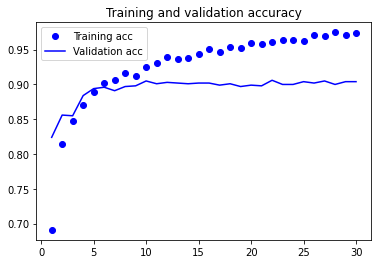

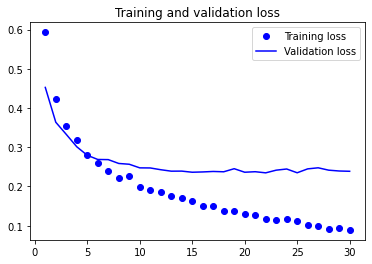

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We've reached a validation accuracy of about 90%—much better than achieved in the previous section with the small model trained from scratch. But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. **That’s because this technique doesn’t use data augmentation**, which is essential for preventing overfitting with small image datasets.

### Feature extraction with data augmentation
Now, let’s review the second technique for doing feature extraction, which is much slower and more expensive, but allows you to use data augmentation during training: **extending the `conv_base` model and running it end to end on the inputs.**

> **Note:** This technique is so expensive that you should only attempt it if you have access to a GPU—it’s absolutely intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like `conv_base`) to a `Sequential` model just like you would add a layer.

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. **Freezing** a layer or set of layers **means preventing their weights from being updated during training.** If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its `trainable` attribute to `False`:

In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector).

Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/home/gary/.cache/pypoetry/virtualenvs/deep-learning-with-python-qnB20RqU-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 [==============================] - 16s 151ms/step - loss: 0.6039 - acc: 0.6730 - val_loss: 0.4583 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 15s 150ms/step - loss: 0.4890 - acc: 0.7810 - val_loss: 0.3716 - val_acc: 0.8570
Epoch 3/30
100/100 [==============================] - 15s 149ms/step - loss: 0.4379 - acc: 0.8090 - val_loss: 0.3282 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 15s 149ms/step - loss: 0.4025 - acc: 0.8200 - val_loss: 0.3117 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 15s 147ms/step - loss: 0.3855 - acc: 0.8330 - val_loss: 0.2911 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 15s 149ms/step - loss: 0.3578 - acc: 0.8490 - val_loss: 0.2854 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 15s 149ms/step - loss: 0.3554 - acc: 0.8455 - val_loss: 0.2794 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 1

This is much better than you achieved with the small convnet trained from scratch. Although, it should be noted that without a dedicated GPU, this would **not be worth the performance increase over the Feature Extraction without data augmentation**.

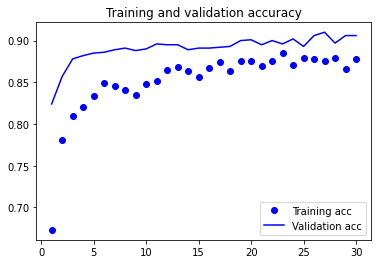

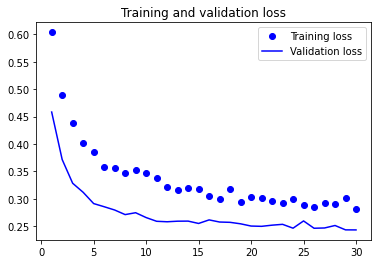

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. **Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.** This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

Earlier, it was explained why it is necessary to freeze *all* the weights of the convolution base. For the same reason, it’s only possible to fine-tune the *top layers* of the convolutional base once the classifier on top has already been trained.

Thus the steps for fine-tuning a network are as follow:
1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.


We've already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze your `conv_base` and then freeze individual layers inside it.

As a reminder, this is what your convolutional base looks like:

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We’ll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable. Recall that in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base.

Let’s set this up, starting from where we left off in the previous example.

In [15]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can begin fine-tuning the network. We’ll do this with the `RMSProp` optimizer, using a very low learning rate. **The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning.** Updates that are too large may harm these representations.

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 16s 149ms/step - loss: 0.2862 - acc: 0.8725 - val_loss: 0.2315 - val_acc: 0.9120
Epoch 2/100
100/100 [==============================] - 15s 149ms/step - loss: 0.2693 - acc: 0.8895 - val_loss: 0.2087 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2449 - acc: 0.8895 - val_loss: 0.2079 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2073 - acc: 0.9110 - val_loss: 0.2108 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 15s 149ms/step - loss: 0.2100 - acc: 0.9115 - val_loss: 0.1916 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 15s 149ms/step - loss: 0.1935 - acc: 0.9200 - val_loss: 0.1892 - val_acc: 0.9250
Epoch 7/100
100/100 [==============================] - 15s 148ms/step - loss: 0.1797 - acc: 0.9270 - val_loss: 0.1959 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0307 - acc: 0.9900 - val_loss: 0.2687 - val_acc: 0.9310
Epoch 62/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0371 - acc: 0.9865 - val_loss: 0.2332 - val_acc: 0.9310
Epoch 63/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0251 - acc: 0.9905 - val_loss: 0.3293 - val_acc: 0.9270
Epoch 64/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0316 - acc: 0.9915 - val_loss: 0.2082 - val_acc: 0.9400
Epoch 65/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0315 - acc: 0.9900 - val_loss: 0.2416 - val_acc: 0.9410
Epoch 66/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0323 - acc: 0.9885 - val_loss: 0.3176 - val_acc: 0.9290
Epoch 67/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0298 - acc: 0.9915 - val_loss: 0.2616 - val_acc: 0.9340
Epoch 68/100
100/100 [===================

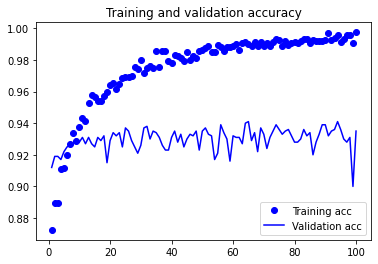

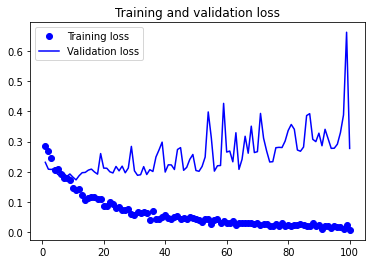

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here’s a trivial utility function to do this.

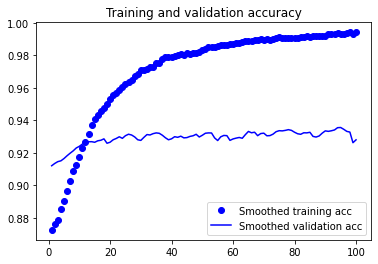

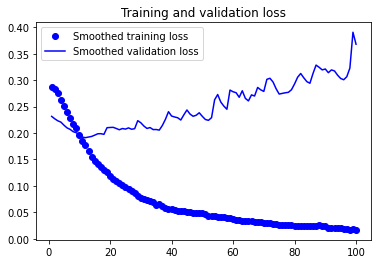

In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy curve look much cleaner. You’re seeing a nice 3% absolute improvement in accuracy from Feature Extraction with data augmentation.

Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). You may wonder, how could accuracy stay stable or improve if the loss isn’t decreasing? The answer is simple: **what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model.** The model may still be improving even if this isn’t reflected in the average loss.

Finally, we will evaluate this model on the test data:

In [20]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 56ms/step - loss: 0.3180 - acc: 0.9390
test acc: 0.9390000104904175


Here you get a test accuracy of 94%.

## Wrapping up
Here’s what you should take away from the exercises in the past two sections:

- **Convnets are the best type of machine-learning models for computer-vision tasks.** It’s possible to train one from scratch even on a very small dataset, with decent results.
- On a small dataset, overfitting will be the main issue. **Data augmentation is a powerful way to fight overfitting when you’re working with image data.**
- It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small image datasets.
- **As a complement to feature extraction, you can use fine-tuning**, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image-classification problems—in particular with small datasets.